In [4]:
# IMPORT STATEMENTS
import re
import numpy as np
from matplotlib import pyplot as plt
get_ipython().magic('matplotlib inline')
import pandas as pd
from collections import Counter
import os
import sys
from scipy.stats import fisher_exact, ttest_ind
import StepMiner as smn
import HegemonUtil as hu
acolor = ["#00CC00", "#fde200","#7557c2",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [17]:
import bone
reload(bone)
class MacAnalysis(bone.MacAnalysis):

    def __init__(self):
        bone.MacAnalysis.__init__(self)
   
    def getGSE14580(self, tn=1):
        self.prepareData("PLP53")
        atype = self.h.getSurvName('c response to infliximab')
        atypes = ['R', 'NR']
        ahash = {'Yes':0, 'No':1}
        self.initData(atype, atypes, ahash)
        
    def getARIJS_1(self, tn=1):
        self.prepareData("CD2","/home/saptarshi.sinha/Hegemon/explore.conf")
        atype = self.h.getSurvName('c response to infliximab (ch1)')
        atypes = ['Yes_Before','No_Before']
        ahash = {'CD_Yes_Before first infliximab treatment':0,'CD_No_Before first infliximab treatment':1,'UC_Yes_Before first infliximab treatment':0,'UC_No_Before first infliximab treatment':1}
        self.initData(atype, atypes, ahash)   
        
    def getVanderGoten(self, tn=1):
        self.prepareData("PLP25")
        activity = self.h.getSurvName("c disease activity")
        atype = self.h.getSurvName("c disease")
        atypes = ['Control', 'UC', 'CD', 'I', 'A', 'NA']
        ahash = {'control':0,
                'active':4, 'inactive':3, 'not applicable': 5}
        if (tn == 2):
            atypes = ['I', 'A']
            ahash = {'active':1, 'inactive':0}
            atype = activity
        self.initData(atype, atypes, ahash) 
        
    def getVanhove(self, dtype=0, tn=1):
        self.prepareData("PLP23")
        activity = self.h.getSurvName("c disease activity")
        atype = self.h.getSurvName("c disease")
        atypes = ['Control', 'UC', 'CD']
        ahash = {'ulcerative colitis':1, "Crohn's disease":2, 'control':0}
        if (tn == 2):
            atypes = ['I', 'A']
            ahash = {'active':1, 'inactive':0}
            atype = activity
        self.initData(atype, atypes, ahash)        

        
def getRanks2(gene_groups, h):
    expr = []
    row_labels = []
    row_ids = []
    row_numhi = []
    ranks = []
    g_ind = 0
    counts = []
    for s in gene_groups:
        count = 0
        avgrank = [0 for i in h.aRange()]
        for gn in s:
          for id in h.getIDs(gn):
            e = h.getExprData(id);
            t = h.getThrData(id);
            if t is None or len(e) != (h.getEnd()+1):
                continue
            v = np.array([float(e[i]) if e[i] != "" else 0 for i in h.aRange()])
            te = []
            sd = np.std(v)
            if sd == np.NaN or sd <= 0:
                continue
            for i in h.aRange():
                if (e[i] != ""):
                    v1 = (float(e[i]) - t[3]) / 3;
                    if sd > 0:
                        v1 = v1 / sd
                else:
                    v1 = -t[3]/3/sd
                avgrank[i-h.start] += v1
                te.append(v1)
            expr.append(te)
            row_labels.append(h.getSimpleName(id))
            row_ids.append(id)
            v1 = [g_ind, sum(v > t[3])]
            if g_ind > 3:
                v1 = [g_ind, sum(v <= t[3])]
            else:
                v1 = [g_ind, sum(v > t[3])]
            row_numhi.append(v1)
            count += 1
            #if count > 200:
            #    break
        ranks.append(avgrank)
        g_ind += 1
        counts += [count]
    print(counts)
    return ranks, row_labels, row_ids, row_numhi, expr
        
        
        
def plotViolinBar(ana, desc=None):
    fig = plt.figure(figsize=(5,5), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
#    return fig

def plotDensityBar(ana, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    ax = ana.densityPlot(ax2, acolor)
    return fig

def processData(ana, l1, wt1, desc=None, violin=1):
    ana.orderData(l1, wt1)
    if (violin == 1):
        return plotViolinBar(ana, desc)
def processDataDf(ana, l1, wt1, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)

    c_dict, fpr, tpr, roc_auc = bone.processGeneGroupsDf(ana, l1, wt1)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
    return fig

def getOrder(ana, l1):
    from scipy.stats import fisher_exact, ttest_ind
    res = []
    for s in l1:
        for gn in s:
            id1 = ana.h.getBestID(ana.h.getIDs(gn).keys())
            if id1 is None:
                continue
            e = ana.h.getExprData(id1)
            v1 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[0]])
            v2 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[1]])
            t, p = ttest_ind(v1,v2,equal_var=False)
            res += [[id1, ana.h.getSimpleName(id1),
                   t, p, np.mean(v1)-np.mean(v2)]]
    return pd.DataFrame(res, columns=['ProbeID', 'Name', 'T', 'p', 'Diff'])
def plotVolcano(ana, genes, cfile, ylim=[0, 10.5], xlim=[-6, 6]):
    df = processGenes(ana.h, [ana.state[0], ana.state[1]], genes)
    df['Size'] = 10
    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    crcdf = pd.read_csv(cfile)
    crcdf['logp'] = -np.log10(crcdf['pvalue'])
    ax = sns.scatterplot('log2FoldChange', 'logp', size=0.1, color='0.8',
                         edgecolor="none", data=crcdf)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.legend().set_visible(False)
    import io
    import base64
    buffer = io.BytesIO()
    fig.savefig(buffer, format='jpg')
    buffer.seek(0)
    volcano = base64.b64encode(buffer.read())
    from PIL import Image, ImageDraw
    buffer.seek(0)
    img = Image.open(buffer)
    x = list(ax.bbox.bounds)
    x[2] = x[2] + x[0]
    x[3] = x[3] + x[1] - 2
    x[1] = x[1] - 2
    img = img.crop(x)

    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    ax = sns.scatterplot('Diff', 'logp', hue='Diff', palette='vlag',
                         data=df, size='Size', size_norm=(0, 10), 
                         edgecolor="none", zorder=2, ax=ax)
    ax.legend().set_visible(False)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    for i in df.index:
        ax.text(df['Diff'][i]+.02, df['logp'][i], str(df['Name'][i]))
    ax.imshow(img,
              aspect = ax.get_aspect(),
              extent = ax.get_xlim() + ax.get_ylim(),
              zorder = 1) #put the map under the heatmap
    return ax

def savePList(ofile, ana, l1):
    df = getOrder(ana, l1)
    df1 = df.sort_values(by=['T'], ascending=True)
    bone.saveList(ofile, df1['Name'])


def getSource(self):
    if 'source' in self.hash:
        return self.hash['source']
    print(f"source missing in hash: {self.hash}")
    return 'unknown_source'
    

In [18]:
wt1, l1 = [1], [bone.getEntries("34.txt", 0)]#import 34 gene 

Arijs 2009 IFX UC (n = 30)
GSE14580 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP53
24 8 16 0 PLP53
[67]


NameError: name 'plotTitleBar' is not defined

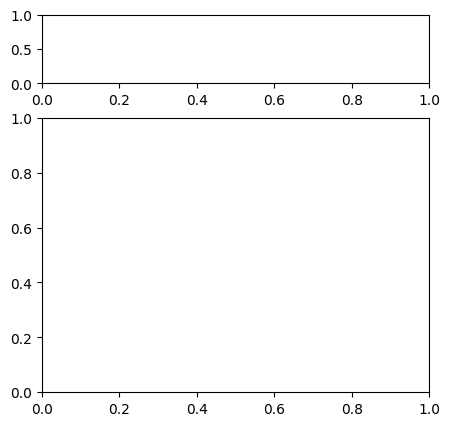

In [19]:
ana = MacAnalysis()
ana.getGSE14580()
processData(ana, l1, wt1, desc=None, violin=1)

Arijs 2009 CD2 (n = 133)
GSE16879 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=CD2
61 28 33 0 CD2
[67]


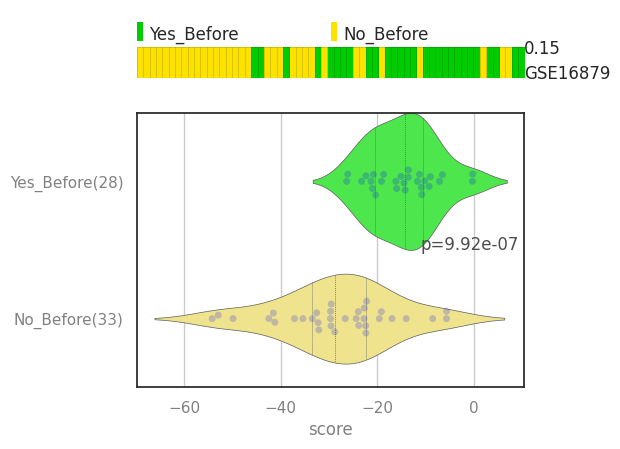

In [42]:
ana.getARIJS_1()
processData(ana, l1, wt1, desc=None, violin=1)

Van der Goten 2014 IBD (n = 21)
GSE48958 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP25
13 6 7 0 PLP25
[35]


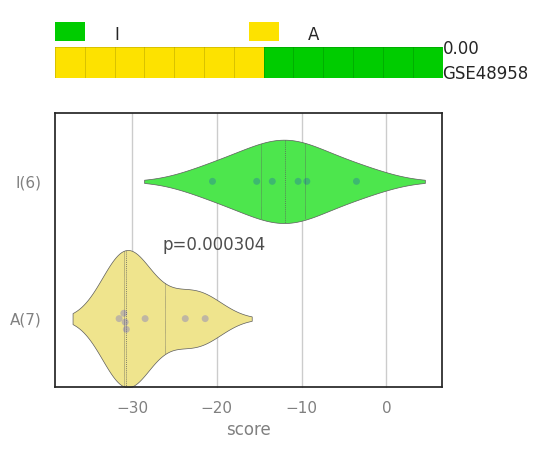

In [52]:
ana.getVanderGoten(tn=2)
processData(ana, l1, wt1, desc=None, violin=1)

Vanhove 2015 IBD (n = 116)
GSE59071 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=PLP23
105 23 82 0 PLP23
[35]


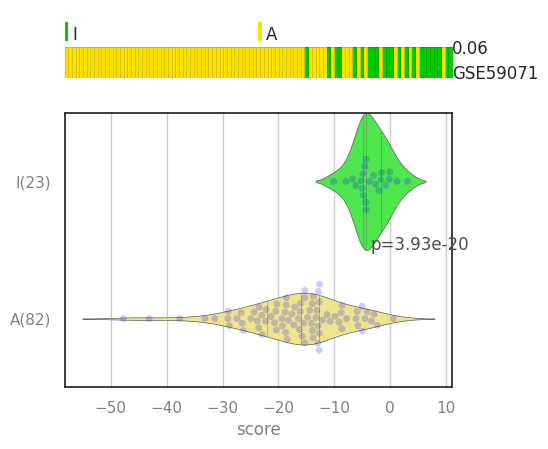

In [51]:
ana.getVanhove(tn=2)
processData(ana, l1, wt1, desc=None, violin=1)

STELLARA (n = 148)
GSE207022 http://hegemon.ucsd.edu/Tools/explore.php?key=blood:leukemia&id=SS62.2
101 12 89 0 SS62.2
[64]


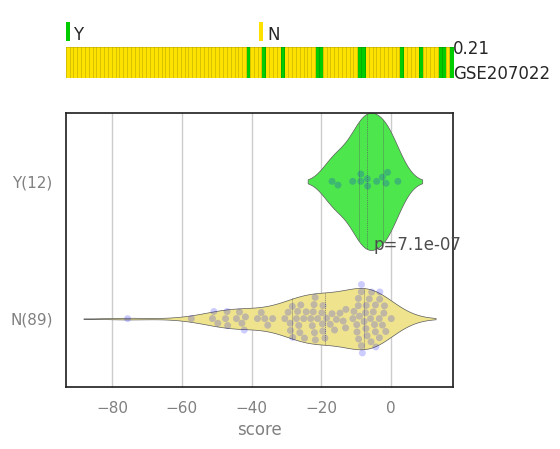

In [38]:
ana.getSTELLARA()
processData(ana, l1, wt1, desc=None, violin=1)

In [ ]:
ana.getARIJS_1()
processData(ana, l1, wt1, desc=None, violin=1)

In [7]:
A=[-3.3, -5.2, -5.8, -1.6, -9, -3, -4.956048454, -5, -5.6, -2.9, -6, -5.8, -3.9, -10.7, -5.225393665, -6.654011743, -6.261914762, -6.5, -2.150780094, -2.5, -13.5, -5.5, -9.9, -3.5, -8, -2.9, -16.36497965, -16.4, -8.398286705, -9.1, -10.41507064, -11.41491969, -5.906973302, -6.122055874, -3.000035509, -3.396041686, -2.439044893, -2.983426237, -5.113004339, -5.421308362]

In [8]:
#Stepminer threshold calculation
thr = hu.getThrData(A)
fthr = thr[0]
fthr

-7.817452777405956